# Assignment 1

Deadline: 19.03.2025, 12:00 CET

<Add your name, student-id and emal address>

In [1]:
# Import standard libraries
import os
import sys
import timeit # To compute runtimes
from typing import Optional

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local modules
project_root = os.path.dirname(os.path.dirname(os.getcwd()))
src_path = os.path.join(project_root, 'qpmwp-course\\src')
sys.path.append(project_root)
sys.path.append(src_path)
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.constraints import Constraints
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.quadratic_program import QuadraticProgram, USABLE_SOLVERS

## 1. Solver Horse Race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

In [2]:

# Set the dimensions
T = 1000  # Number of time periods
N = 100   # Number of assets

# Generate a random mean vector and covariance matrix for the multivariate normal distribution
mean = np.random.uniform(-0.0005, 0.0005, N)
A = np.random.uniform(0, 0.0113, size=(N, N))
cov = np.dot(A, A.transpose())

# Generate the Multivariate-Normal random dataset
data = np.random.multivariate_normal(mean, cov, size=T)

print('multivariate normal shape =', data.shape)

# Convert the dataset to a DataFrame for easier manipulation
df = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# Compute the vector of expected returns (mean returns) from df
scalefactor = 256
expected_return = ExpectedReturn(method='geometric', scalefactor = scalefactor)
q =  expected_return.estimate(df, inplace = False)

# Compute the covariance matrix from df
covariance = Covariance(method='pearson')
P = covariance.estimate(df, inplace=False)

# Display the results
print("Vector of expected returns (q):")
print(q)

print("\nCovariance matrix (P):")
print(P)


multivariate normal shape = (1000, 100)
Vector of expected returns (q):
Asset_1     -0.485704
Asset_2     -0.634514
Asset_3     -0.501745
Asset_4     -0.529102
Asset_5     -0.664059
               ...   
Asset_96    -0.706868
Asset_97    -0.325534
Asset_98    -0.660473
Asset_99    -0.486837
Asset_100   -0.485810
Length: 100, dtype: float64

Covariance matrix (P):
            Asset_1   Asset_2   Asset_3   Asset_4   Asset_5   Asset_6  \
Asset_1    0.004586  0.003094  0.003086  0.003315  0.003492  0.002952   
Asset_2    0.003094  0.004124  0.003141  0.003169  0.003409  0.003009   
Asset_3    0.003086  0.003141  0.004171  0.003124  0.003269  0.002871   
Asset_4    0.003315  0.003169  0.003124  0.004135  0.003149  0.002821   
Asset_5    0.003492  0.003409  0.003269  0.003149  0.004662  0.003179   
...             ...       ...       ...       ...       ...       ...   
Asset_96   0.003157  0.002967  0.002990  0.003082  0.003402  0.002773   
Asset_97   0.002950  0.002987  0.002763  0.002869 

In [3]:
# average return over all assets
print(q.mean(axis=0))

-0.5058759988256177


### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

In [4]:
# Instantiate the Constraints class
constraints = Constraints(ids = df.columns.tolist())

# Add budget constraint
constraints.add_budget(rhs=1, sense='=')

# Add box constraints (i.e., lower and upper bounds)
constraints.add_box(lower=0.0, upper=0.2)

# Add linear constraints
G = pd.DataFrame(np.zeros((3, N)), columns = constraints.ids)
G.iloc[0, 0:30] = 1
G.iloc[1, 30:60] = 1
G.iloc[2, 60:] = 1
h = pd.Series([0.3, 0.4, 0.5])

constraints.add_linear(G=G, rhs=h, sense='<=')

### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

- runtime
- accuracy: value of the primal problem.
- reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution). 




In [ ]:
# Extract the constraints in the format required by the solver
GhAb = constraints.to_GhAb()

# Loop over solvers, instantiate the quadratic program, solve it and store the results
import qpsolvers

solver_array = qpsolvers.available_solvers # array of available solvers

data = {
    'solution_found': [False]*len(solver_array),
    'objective': [None] * len(solver_array),
    'primal_residual': [float('nan')] * len(solver_array),
    'dual_residual': [float('nan')] * len(solver_array),
    'duality_gap': [float('nan')] * len(solver_array),
    'runtime': [float('nan')] * len(solver_array),
}
Results_df  = pd.DataFrame(data, index=solver_array)

for solver in solver_array:
    mv = MeanVariance(
        covariance=covariance,
        expected_return=expected_return,
        constraints=constraints,
        risk_aversion=1,
        solver_name=solver,
    )
    optimization_data = OptimizationData(return_series=df)
    
    mv.set_objective(optimization_data=optimization_data)

    mv.solve()

    optimal_w = pd.Series(mv.results['weights'], index=df.columns)

    # calculating residuals
    r_budget = optimal_w.sum() - 1
    r_lower = sum([w for w in optimal_w if w<0])
    r_upper = sum([w-0.2 for w in optimal_w if w>0.2])
    r_group1 = 0
    r_group2 = 0
    r_group3 = 0
    if sum(optimal_w[:30]) > 0.3:
        r_group1 = sum(optimal_w[:30]) - 0.3
    if sum(optimal_w[31:60]) > 0.4:
        r_group2 = sum(optimal_w[31:60]) - 0.4
    if sum(optimal_w[61:100]) > 0.5:
        r_group3 = sum(optimal_w[61:100]) - 0.5

    r_array = np.array([r_budget, r_lower, r_upper, r_group1, r_group2, r_group3])

    Results_df.loc[solver, 'solution_found'] = mv.results['status']
    Results_df.loc[solver, 'objective'] = (-1*optimal_w @ q) + (optimal_w @ P @ optimal_w.T)
    Results_df.loc[solver, 'primal_residual'] = np.linalg.norm(r_array)
    

Print and visualize the results

clarabel   -1.597891
cvxopt     -1.597891
daqp       -1.597891
ecos       -1.597891
highs      -1.597891
osqp       -1.597891
piqp       -1.597891
qpalm      -1.597891
quadprog   -1.597891
scs        -1.597891
qpax       -1.597891
Name: objective, dtype: object


<Axes: >

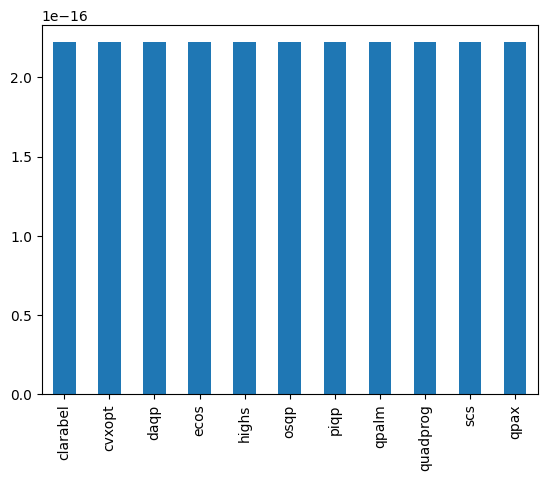

In [74]:
#<your code here>
print(Results_df['objective'])
Results_df['primal_residual'].plot(kind='bar')

## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).


In [ ]:
# Define class MinVariance
class MinVariance(Optimization):

    def __init__(self,
                 constraints: Constraints,
                 covariance: Optional[Covariance] = None,
                 **kwargs):
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance

    def set_objective(self, optimization_data: OptimizationData) -> None:
        #<your code here>

    def solve(self) -> None:
        if self.params.get('solver_name') == 'analytical':
            #<your code here>
            return None
        else:
            return super().solve()


# Create a constraints object with just a budget constraint
#<your code here>

# Instantiate the MinVariance class
#<your code here>

# Prepare the optimization data and prepare the optimization problem
#<your code here>

# Solve the optimization problem and print the weights
#<your code here>